In [1]:
###Load packages###
import pandas as pd
import os
import ast
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import numpy as np

###Load cleaned dataset###

#Set file paths
topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'Study2.0Pilot'
cleandir = os.path.join(topdir, f'data/{study}/Cleaned')
outputdir = os.path.join(topdir, f'Analysis/{study}')

#Read in cleaned data (from cleaning scripts)
accomodate_path = os.path.join(cleandir, f'{study}Accommodate.csv')
predict_path   = os.path.join(cleandir, f'{study}Predict.csv')

df_accommodate = pd.read_csv(accomodate_path)
df_predict   = pd.read_csv(predict_path)

df_accommodate['task'] = 'accommodate'
df_predict['task']   = 'predict'


print("Accommodate columns:", df_accommodate.columns.tolist())
print("Predict columns:", df_predict.columns.tolist())


Accommodate columns: ['participant', 'free_texts', 'feedback', 'food_amount', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_wing', 'training_color', 'testing_categories', 'conditionOrder', 'training_image_order', 'attention_check', 'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 'color_high', 'color_low', 'wing_high', 'wing_low', 'tail_high', 'tail_low', 'wing_discrete_slider.response', 'wing_direction_slider.response', 'wing_continuous_slider.response', 'color_discrete_slider.response', 'color_direction_slider.response', 'color_continuous_slider.response', 'tail_discrete_slider.response', 'tail_direction_slider.response', 'tail_continuous_slider.response', 'task']
Predict columns: ['participant', 'training_responses', 'food_amount', 'error', 'feedback', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_wing', 'training_color', 'testing_categories', 'c

Data Processing (fix string representations of lists)

In [2]:
#Converting string representations of lists back to lists

def parse_list_column(x):
    """take column entries that are strings representing lists and convert them to actual lists"""
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            return ast.literal_eval(x)
        else:
            return [x]
    return []
for col in ['training_tail', 'training_wing', 'training_color', 'training_image_order', 'training_categories', 'testing_categories']:
    df_accommodate[col] = df_accommodate[col].apply(parse_list_column)
    df_predict[col]   = df_predict[col].apply(parse_list_column)

df_accommodate['testing_responses'] = df_accommodate['testing_responses'].apply(ast.literal_eval)
df_accommodate['food_amount'] = df_accommodate['food_amount'].apply(ast.literal_eval)
df_accommodate['testing_image_order'] = df_accommodate['testing_image_order'].apply(ast.literal_eval)
df_predict['testing_responses'] = df_predict['testing_responses'].apply(ast.literal_eval)
df_predict['food_amount'] = df_predict['food_amount'].apply(ast.literal_eval)
df_predict['testing_image_order'] = df_predict['testing_image_order'].apply(ast.literal_eval)
#Combine the dataframes and create an arbitrary column for participant numbering (the yoked orders are already stored in 'conditionOrder')
df_combined = pd.concat([df_accommodate, df_predict], ignore_index=True)
df_combined['participant'] = range(1, len(df_combined) + 1)



Sanity Checks

In [3]:
#Look at food amount in trainingby participant/category in accomodate task
df = df_accommodate[['participant', 'training_categories', 'food_amount']]
df_long = (
    df
    .explode(['training_categories', 'food_amount'])
    .rename(columns={'training_categories': 'category'})
)
avg_food = (
    df_long
    .groupby(['category'], as_index=False)
    ['food_amount']
    .mean()
)
print(avg_food)

  category food_amount
0     high    6.833333
1      low    3.066667
2   medium    5.170833


In [4]:
#Look at food amount by participant/category in predict task
df = df_predict[['participant', 'training_categories', 'food_amount']]
df_long = (
    df
    .explode(['training_categories', 'food_amount'])
    .rename(columns={'training_categories': 'category'})
)
avg_food = (
    df_long
    .groupby(['category'], as_index=False)
    ['food_amount']
    .mean()
)
print(avg_food)

  category food_amount
0     high    6.833333
1      low    3.066667
2   medium    5.170833


In [5]:
#Overall means by category in accommodate task (participant responses)
df = df_accommodate[['participant', 'testing_categories', 'testing_responses']]
df_long = (
    df
    .explode(['testing_categories', 'testing_responses'])
    .rename(columns={'testing_categories': 'category'})
)
#print(df_long)
avg_rating = (
    df_long
    .groupby(['category'], as_index=False)
    ['testing_responses']
    .mean()
)
print(avg_rating)

  category testing_responses
0     high             6.375
1      low               3.7
2   medium             5.225


In [6]:
#Overall means by actual testing category in prediction task
df = df_predict[['participant', 'testing_categories', 'testing_responses']]
df_long = (
    df
    .explode(['testing_categories', 'testing_responses'])
    .rename(columns={'testing_categories': 'category'})
)
#print(df_long)
avg_rating = (
    df_long
    .groupby(['category'], as_index=False)
    ['testing_responses']
    .mean()
)
print(avg_rating)

  category testing_responses
0     high               6.4
1      low             3.925
2   medium            4.9875


In [7]:
df_combined.groupby('irrelevant_dim')['wing_high'].value_counts()


irrelevant_dim  wing_high
color           T            10
tail            N            10
wing            T            16
                N             4
Name: count, dtype: int64

In [8]:
#Checking to see how often a feature dimension was said to be relevant, relative to when it was actually relevant
#Point of test: get a subjective sense for whether participants are more likely to say a given feature is relevant
#Irrespective of whether it actually is relevant

cols_to_show = [
    'conditionOrder'
    'wing_direction_slider.response',
    'wing_high',
    'wing_continuous_slider.response'
]

mask = (
    (df_combined['relevant_dim_1'] == 'wing') |
    (df_combined['relevant_dim_2'] == 'wing')
)


#print(df_combined.loc[mask, cols_to_show])
cols_to_show = [
    'wing_direction_slider.response',
    'wing_high',
    'wing_continuous_slider.response'
]

mask = (
    (df_combined['irrelevant_dim'] == 'wing')
)

#print(df_combined.loc[mask, cols_to_show])
print(df_combined[cols_to_show])

   wing_direction_slider.response wing_high  wing_continuous_slider.response
0                            Paws         N                              6.0
1                             NaN         T                              NaN
2                           Wings         N                              5.0
3                           Wings         T                              6.0
4                            Paws         N                              5.0
5                           Wings         T                              3.0
6                           Wings         T                              6.0
7                           Wings         T                              4.0
8                            Paws         N                              5.0
9                           Wings         T                              5.0
10                          Wings         T                              2.0
11                          Wings         T                              1.0

Timing

task
accommodate    472.340390
predict        810.248215
Name: trial_stop_time, dtype: float64


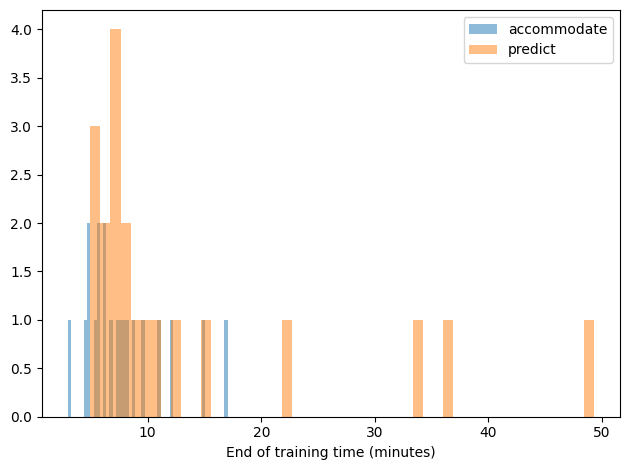

In [9]:
#Look at average time across task
df_combined['trial_stop_time'].describe()
avg_time = df_combined.groupby(['task'])['trial_stop_time'].mean()
print(avg_time)

for task, subdf in df_combined.groupby('task'):
    plt.hist(
        subdf['trial_stop_time']/60,
        bins=50,
        alpha=0.5,
        label=task
    )

plt.xlabel('End of training time (minutes)')
plt.legend()
plt.tight_layout()
#plt.savefig(os.path.join(outputdir, 'Figure1TrialStopTimeByTask.png'))
plt.show()


**Primary Analysis #1**

Part 1: Model Parameter Score Complexity across conditions

In [10]:
import pandas as pd


#Loop through rows and determine model parameter score for each participant

participant_rows = []

for _, row in df_combined.iterrows():
    tail_yes  = 1 if row['tail_discrete_slider.response']  == 'Yes' else 0
    wing_yes = 1 if row['wing_discrete_slider.response'] == 'Yes' else 0
    color_yes = 1 if row['color_discrete_slider.response'] == 'Yes' else 0
    model_param_score = tail_yes + wing_yes + color_yes


    participant_rows.append({
        'participant': row['participant'],
        'task': row['task'],  # predict vs accommodate
        'model_param_score': model_param_score,
        'conditionOrder': row['conditionOrder'],
        'irrelevant_dim': row['irrelevant_dim'],
        'wing_high': row['wing_high'],
        'overfit': model_param_score == 3 #overfit if all 3 dimensions selected
    })

df_params = pd.DataFrame(participant_rows)

#Compare overfit vs not by condition
contingency = pd.crosstab(
    df_params['task'],
    df_params['overfit']
)

print(contingency)
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-square = {chi2:.3f}")
print(f"df = {dof}")
print(f"p-value = {p:.4f}")


overfit      False  True 
task                     
accommodate     10     10
predict         12      8
Chi-square = 0.101
df = 1
p-value = 0.7506


In [11]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Overfit is numeric 0/1
df_params['overfit'] = df_params['overfit'].astype(int)

# Convert categorical columns to strings
df_params['task'] = df_params['task'].astype(str)
df_params['irrelevant_dim'] = df_params['irrelevant_dim'].astype(str)
df_params['wing_high'] = df_params['wing_high'].astype(str)

pd.crosstab(
    [df_params['task'], df_params['irrelevant_dim'], df_params['wing_high']],
    df_params['overfit'],
    margins=True
)



overfit                                0   1  All
task        irrelevant_dim wing_high             
accommodate color          T           2   3    5
            tail           N           4   1    5
            wing           N           0   2    2
                           T           4   4    8
predict     color          T           3   2    5
            tail           N           4   1    5
            wing           N           1   1    2
                           T           4   4    8
All                                   22  18   40

Part 2: Testing distribution of all model parameter scores by task

In [12]:
contingency_all = pd.crosstab(
    df_params['task'],
    df_params['model_param_score']
)

print(contingency_all)

chi2, p, dof, expected = chi2_contingency(contingency_all)

print(f"Chi-square = {chi2:.3f}")
print(f"df = {dof}")
print(f"p-value = {p:.4f}")

ax = contingency_all.plot(
    kind="bar",
    stacked=True,
    figsize=(8, 5)
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel("Task")
ax.set_ylabel("Count")
#ax.set_title("Model Parameter Scores by Task")

# Add numerical labels with the count
for container in ax.containers:
    ax.bar_label(
        container,
        label_type="center",
        fontsize=9
    )
plt.legend(title="Model parameter score", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
'''
plt.savefig(
    os.path.join(outputdir, "Figure2_TaskByModelParamScore_StackedBars.png"),
    dpi=300
)
'''
plt.close()



model_param_score  0  1  2   3
task                          
accommodate        1  2  7  10
predict            1  4  7   8
Chi-square = 0.889
df = 3
p-value = 0.8281


**Primary Analysis #2: Predicting Feature Importance Ratings**

In [13]:
#Create map from short codes to feature descriptions

wing_map = {
    'wings': 't',
    'paws': 'n'
}

color_map = {
    'blue': 'b',
    'yellow': 'y'
}

tail_map = {
    'curly': 'c',
    'straight': 's'
}


feature_maps = {
    'wing': wing_map,
    'color': color_map,
    'tail': tail_map
}


In [14]:
#Compute feature importance scores

from doctest import debug


def compute_feature_importance_from_df(df):
    """
    Compute numeric feature importance scores(-7 to 7) for each participant,
    based on the saved slider_responses and the feature _high/_low mapping.
    This is computed based on whether a feature was really relevant (positive sign) or irrelevant (negative sign).
    0 = no response or feature was not thought to be relevant
    columns:
      - wings_discrete_slider.response, wings_direction_slider.response, wings_continuous_slider.response
      - color_discrete_slider.response, ...
      - tail_discrete_slider.response, ...
      - wings_high, wings_low, color_high, color_low, tail_high, tail_low
    """
    features = ['wing', 'color', 'tail']
    
    def compute_row_importance(row, feat):
        disc = row[f'{feat}_discrete_slider.response']
        dirc = row[f'{feat}_direction_slider.response']
        cont = row[f'{feat}_continuous_slider.response']

        #If they said a feature wasn't relevant, then importance is 0
        
        if disc == 'No' or pd.isna(disc):
            return 0.0
        
        # Make sure continuous slider value exists, if not, set it to 0
        cont_val = float(cont) if not pd.isna(cont) else 0.0

        # Get mapping from long to short feature name
        mapping = feature_maps.get(feat, {})

        # Normalize strings: strip whitespace, collapse multiple spaces, lower-case
        def normalize_str(s):
            """Strip leading/trailing whitespace and collapse internal multiple spaces."""

            if isinstance(s, str):
                return " ".join(s.split()).lower()
            return ""

        #Name of features need to be normalized for comparison using the mapping
        dirc_norm = normalize_str(dirc)

        #Get internal short code for selected feature direction
        internal_dirc = mapping.get(dirc_norm, None)
        
        high_val = normalize_str(row[f'{feat}_high'])
        low_val  = normalize_str(row[f'{feat}_low'])

        
        # Debug print statement (make sure mappings look right)
        debug = True
        if debug:
            print('response:', repr(dirc_norm), 'internal:', repr(internal_dirc), 
                'high:', repr(high_val), 'low:', repr(low_val))
            

        #If they correctly selected the high feature, assign positive sign
        if internal_dirc == high_val:
            sign = 1
        #If they incorrectly selected the low feature, assign negative sign
        elif internal_dirc == low_val:
            if debug:
                print('in negative')
            sign = -1
        else:
            if debug:
                print('in empty')
            sign = 0
            cont_val = 0.0

        # Add sign to continuous value
        importance = cont_val * sign

        return importance

    
    # Compute for each feature
    for feat in features:
        df[f'{feat}_importance'] = df.apply(lambda row: compute_row_importance(row, feat), axis=1)
    
    return df

df_combined = compute_feature_importance_from_df(df_combined)
if debug:
    print(df_combined['wing_importance'])

response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'wings' internal: 't' high: 'n' low: 't'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'wings' internal: 't' high: 'n' low: 't'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'paws' internal: 'n' high: 'n' low: 't'
response: 'paws' internal: 'n' high: 't' low: 'n'
in negative
response: 'wings' internal: 't' high: 't' low: 'n'
response: 'wings' internal: 't' high: 'n' low: 't'
i

In [15]:
import pandas as pd
"""Reshape to long format with 1 row per participant x feature dimension"""
# Keep only necessary columns
cols_to_keep = [
    'participant', 'task', 
    'wing_importance', 'color_importance', 'tail_importance',
    'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 'wing_high'
]

df_long = df_combined[cols_to_keep].copy()

# Melt importance columns
df_long = df_long.melt(
    id_vars=['participant', 'task', 'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 'wing_high'],
    value_vars=['wing_importance', 'color_importance', 'tail_importance'],
    var_name='feature_dimension',
    value_name='feature_importance'
)

# Simplify feature dimension names
df_long['feature_dimension'] = df_long['feature_dimension'].str.replace('_importance','')

def get_relevance(row):
    if row['feature_dimension'] in [row['relevant_dim_1'], row['relevant_dim_2']]:
        return 'relevant'
    else:
        return 'irrelevant'

df_long['feature_relevance'] = df_long.apply(get_relevance, axis=1)

print(df_long)

     participant         task relevant_dim_1 relevant_dim_2 irrelevant_dim  \
0              1  accommodate          color           wing           tail   
1              2  accommodate          color           tail           wing   
2              3  accommodate           wing          color           tail   
3              4  accommodate           tail          color           wing   
4              5  accommodate          color           wing           tail   
..           ...          ...            ...            ...            ...   
115           36      predict           wing          color           tail   
116           37      predict          color           wing           tail   
117           38      predict           tail           wing          color   
118           39      predict           tail          color           wing   
119           40      predict           tail          color           wing   

    wing_high feature_dimension  feature_importance feature_rel

In [16]:
print(df_long.groupby('feature_dimension')['feature_relevance'].describe())

                  count unique       top freq
feature_dimension                            
color                40      2  relevant   30
tail                 40      2  relevant   30
wing                 40      2  relevant   20


WING — relevant: 20 points
WING — irrelevant: 20 points
TAIL — relevant: 30 points
TAIL — irrelevant: 10 points
COLOR — relevant: 30 points
COLOR — irrelevant: 10 points


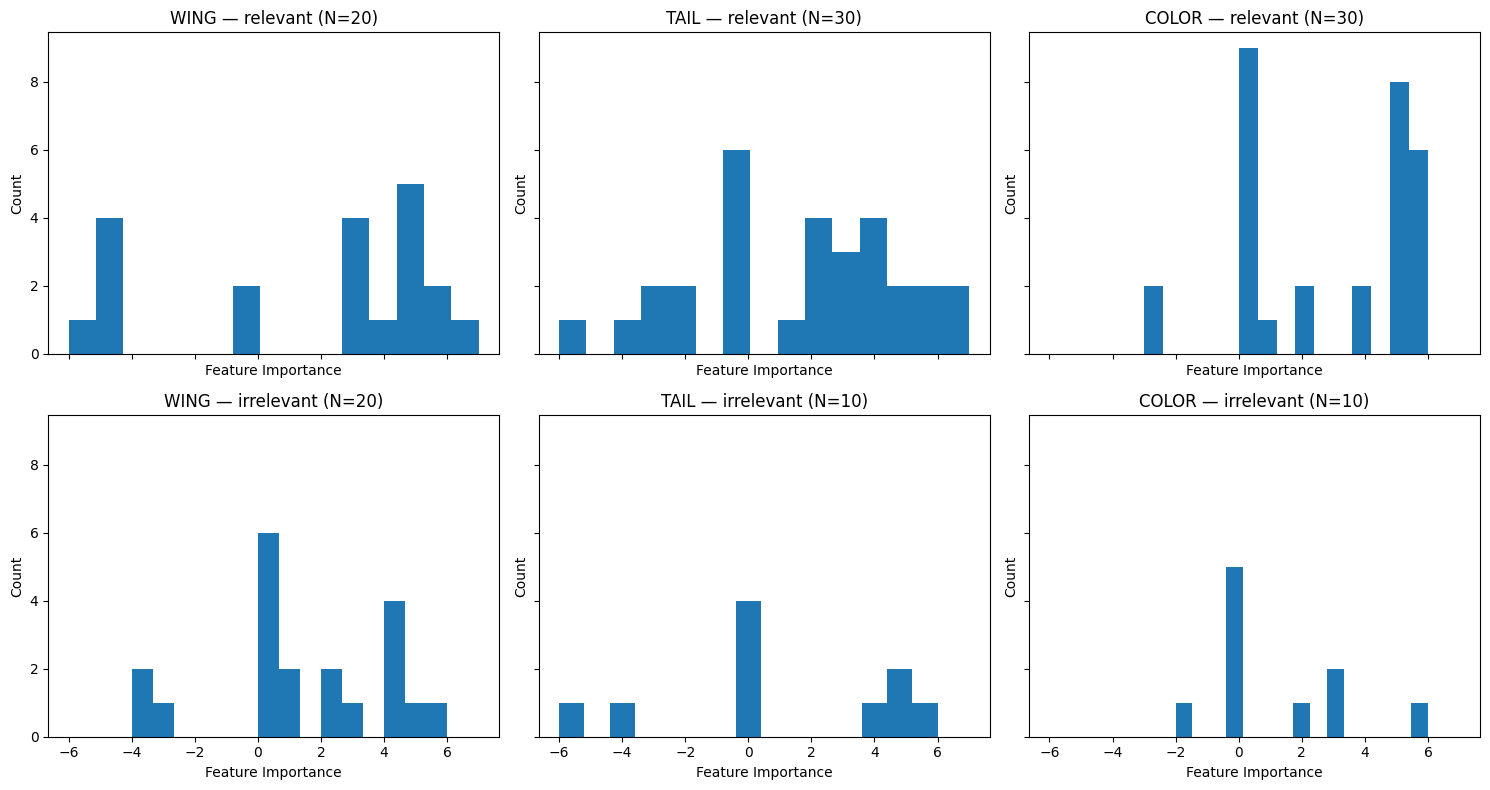

In [17]:
import matplotlib.pyplot as plt

features = ['wing', 'tail', 'color']
relevance_states = ['relevant', 'irrelevant']

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

for col, feat in enumerate(features):
    for row, rel in enumerate(relevance_states):
        
        ax = axes[row, col]
        
        subset = df_long[
            (df_long['feature_dimension'] == feat) &
            (df_long['feature_relevance'] == rel)
        ]
        
        # Number of rows in this subset
        n_points = len(subset)
        print(f"{feat.upper()} — {rel}: {n_points} points")
        
        ax.hist(subset['feature_importance'], bins=15)
        ax.set_title(f"{feat.upper()} — {rel} (N={n_points})")
        ax.set_xlabel("Feature Importance")
        ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


In [ ]:
df_wing = df_long[df_long["feature_dimension"] == "wing"].copy()
df_wing["wing_relevant"] = (df_wing["feature_relevance"] == "relevant").astype(int) #Code relevancy as 0/1
df_wing["wing_present"] = (df_wing["wing_high"] == "T").astype(int) #Code having a wing as 0/1
print(df_wing)

    participant         task relevant_dim_1 relevant_dim_2 irrelevant_dim  \
0             1  accommodate          color           wing           tail   
1             2  accommodate          color           tail           wing   
2             3  accommodate           wing          color           tail   
3             4  accommodate           tail          color           wing   
4             5  accommodate          color           wing           tail   
5             6  accommodate           tail          color           wing   
6             7  accommodate           tail           wing          color   
7             8  accommodate           tail          color           wing   
8             9  accommodate           tail          color           wing   
9            10  accommodate           tail           wing          color   
10           11  accommodate          color           tail           wing   
11           12  accommodate          color           tail           wing   

In [77]:
means = (
    df_wing
    .groupby(["task", "wing_relevant", "wing_present"])["feature_importance"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

print(means)


          task  wing_relevant  wing_present   mean       std  count
0  accommodate              0             0  0.500  6.363961      2
1  accommodate              0             1  2.000  2.203893      8
2  accommodate              1             0  2.800  4.494441      5
3  accommodate              1             1  3.800  2.387467      5
4      predict              0             0  0.500  0.707107      2
5      predict              0             1  0.875  3.181981      8
6      predict              1             0 -4.200  2.387467      5
7      predict              1             1  4.400  1.673320      5


In [78]:
means = (
    df_wing
    .groupby(["task", "wing_present"])["feature_importance"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

print(means)


          task  wing_present      mean       std  count
0  accommodate             0  2.142857  4.634241      7
1  accommodate             1  2.692308  2.358835     13
2      predict             0 -2.857143  3.023716      7
3      predict             1  2.230769  3.166329     13


In [ ]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "feature_importance ~ task + wing_relevant + wing_present + task:wing_relevant",
    df_wing,
    groups=df_wing["participant"]
).fit()

print(model.summary())


                 Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   feature_importance
No. Observations:     40        Method:               REML              
No. Groups:           40        Scale:                5.5114            
Min. group size:      1         Log-Likelihood:       -97.3195          
Max. group size:      1         Converged:            Yes               
Mean group size:      1.0                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.934    1.246 -0.750 0.453 -3.376  1.508
task[T.predict]               -0.900    1.347 -0.668 0.504 -3.539  1.739
wing_relevant                  2.588    1.376  1.881 0.060 -0.109  5.285
task[T.predict]:wing_relevant -2.300    2.076 -1.108 0.268 -6.370  1.

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [214]:
avg_importance = (
    df_long
        .groupby(['feature_relevance'])['feature_importance']
        .mean()
        .reset_index()
)

print(avg_importance)

avg_importance2 = (
    df_long
        .groupby(['feature_dimension'])['feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance2)


avg_importance3 = (
    df_long
        .groupby(['task', 'feature_relevance'])['feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance3)

  feature_relevance  feature_importance
0        irrelevant              1.1750
1          relevant              2.0875
  feature_dimension  feature_importance
0             color               2.375
1              tail               1.500
2              wing               1.475
          task feature_relevance  feature_importance
0  accommodate        irrelevant               1.500
1  accommodate          relevant               2.675
2      predict        irrelevant               0.850
3      predict          relevant               1.500


In [215]:
avg_importance3 = (
    df_long
        .groupby(['task', 'irrelevant_dim', 'wing_high'])['feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance3)

          task irrelevant_dim wing_high  feature_importance
0  accommodate          color         T            2.866667
1  accommodate           tail         N            2.266667
2  accommodate           wing         N            2.333333
3  accommodate           wing         T            1.916667
4      predict          color         T            2.400000
5      predict           tail         N            0.200000
6      predict           wing         N            2.500000
7      predict           wing         T            0.958333


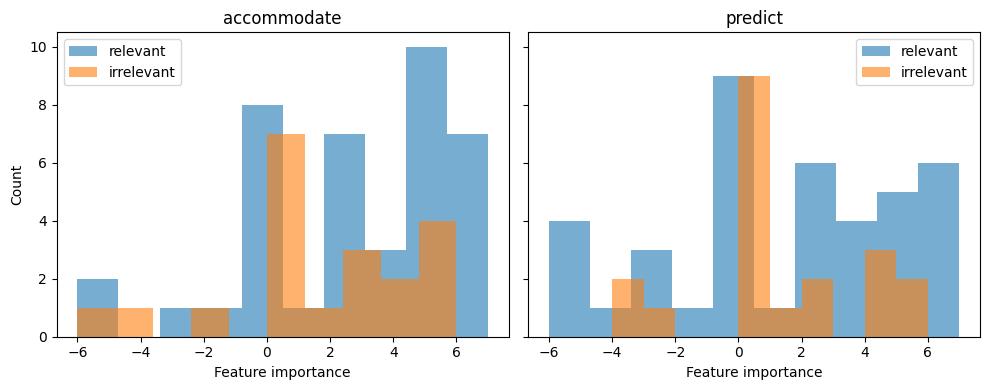

In [167]:
tasks = df_long['task'].unique()

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(tasks),
    figsize=(5 * len(tasks), 4),
    sharey=True
)

if len(tasks) == 1:
    axes = [axes]

for ax, task in zip(axes, tasks):
    for label in ['relevant', 'irrelevant']:
        values = df_long.loc[
            (df_long['task'] == task) &
            (df_long['feature_relevance'] == label),
            'feature_importance'
        ]
        ax.hist(values, bins=10, alpha=0.6, label=label)

    ax.set_title(task)
    ax.set_xlabel("Feature importance")
    ax.legend()

axes[0].set_ylabel("Count")

plt.tight_layout()
#plt.savefig(os.path.join(outputdir, 'Figure3_FeatureImportanceByTaskAndRelevance.png'), dpi=300)
plt.show()


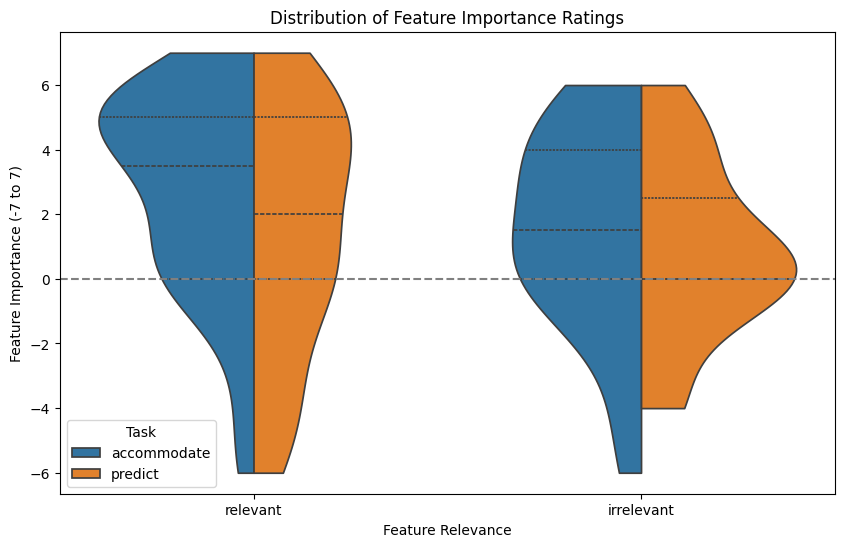

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Violin plot: distribution of ratings by task and relevance
sns.violinplot(
    data=df_long,
    x='feature_relevance',      # relevant / irrelevant
    y='feature_importance',     # -7 to 7
    hue='task',                 # predict / accomodate
    split=True,                 # split the violins by hue
    inner='quartile',            # show median and quartiles
    cut = 0
)

plt.axhline(0, color='gray', linestyle='--')  # line at 0
plt.title('Distribution of Feature Importance Ratings')
plt.ylabel('Feature Importance (-7 to 7)')
plt.xlabel('Feature Relevance')
plt.legend(title='Task')
#plt.savefig(os.path.join(outputdir, 'Figure4_FeatureImportanceByTaskAndRelevanceViolin.png'), dpi=300)
plt.show()


In [17]:
df_long['task'] = df_long['task'].astype('category')  # predict/accomodate
df_long['feature_dimension'] = df_long['feature_dimension'].astype('category')
df_long['feature_relevance'] = df_long['feature_relevance'].astype('category')


In [18]:
import statsmodels.formula.api as smf

# Predicting feature importance from task and feature relevance, with random intercepts for participants
md = smf.mixedlm(
    "feature_importance ~ task * feature_relevance",
    df_long,
    groups=df_long["participant"],  # random intercept per participant
    re_formula="~feature_relevance" # random slopes
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())
mdf.summary().tables[1].to_csv(os.path.join(outputdir, "mixedlm_featureimportance.csv"))

                         Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         feature_importance
No. Observations:         900             Method:                     REML              
No. Groups:               300             Scale:                      10.2616           
Min. group size:          3               Log-Likelihood:             -2383.0065        
Max. group size:          3               Converged:                  Yes               
Mean group size:          3.0                                                           
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.620    0.287  2.157 0.031  0.057  1.183
task[T.predict]                                

In [19]:
#Analyse the absolute value of feature importance ratings (ignoring direction)
df_longAbs = df_long.copy()
df_longAbs["abs_feature_importance"] = df_longAbs["feature_importance"].abs()
avg_importance_task = (
    df_longAbs
        .groupby(['task', 'feature_relevance'])['abs_feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance_task)
avg_importance_relevance = (
    df_longAbs
        .groupby(['feature_relevance'])['abs_feature_importance']
        .mean()
        .reset_index()
)

print(avg_importance_relevance)

avg_importance_feature = (
    df_longAbs
        .groupby(['feature_dimension'])['abs_feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance_feature)

          task feature_relevance  abs_feature_importance
0  accommodate        irrelevant                2.660000
1  accommodate          relevant                3.723333
2      predict        irrelevant                2.833333
3      predict          relevant                3.440000
  feature_relevance  abs_feature_importance
0        irrelevant                2.746667
1          relevant                3.581667
  feature_dimension  abs_feature_importance
0             color                3.016667
1             shape                3.476667
2              tail                3.416667


/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_85942/1409563864.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['task', 'feature_relevance'])['abs_feature_importance']
/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_85942/1409563864.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['feature_relevance'])['abs_feature_importance']
/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_85942/1409563864.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

In [20]:
df_irrel = df_longAbs[df_longAbs["feature_relevance"] == "irrelevant"].copy()

accom_vals = df_irrel[df_irrel["task"]=="accommodate"]["abs_feature_importance"]
predict_vals = df_irrel[df_irrel["task"]=="predict"]["abs_feature_importance"]
mean_accom = np.mean(accom_vals)
mean_predict = np.mean(predict_vals)

print(f"Mean (accommodate) = {mean_accom:.3f}")
print(f"Mean (predict) = {mean_predict:.3f}")
t, p = ttest_ind(predict_vals, accom_vals, equal_var=False)  # Welch's t-test
print(f"t = {t:.3f}, p = {p:.4f}")
summary_df = pd.DataFrame({
    "task": ["accommodate", "predict"],
    "mean_abs_feature_importance": [mean_accom, mean_predict],
    "t_stat": [t, t], 
    "p_value": [p, p]    
})

# Save CSV
summary_df.to_csv(os.path.join(outputdir, "ttest_abs_featureimportance.csv"))

Mean (accommodate) = 2.660
Mean (predict) = 2.833
t = 0.651, p = 0.5158


**Analysis 3: Predicting Food Consumption Ratings**

In [35]:
#Group by average food amount per item in training
df = df_combined[['task', 'training_image_order', 'food_amount', 'conditionOrder']]
df_long2 = (
    df
    .explode(['training_image_order', 'food_amount'])
    .rename(columns={'training_image_order': 'item'})
)
avg_food = (
    df_long2
    .groupby(['task', 'conditionOrder', 'item'], as_index=False)
    ['food_amount']
    .mean()
)
avg_food_train = avg_food.copy()
print(avg_food_train.head(20))


           task  conditionOrder   item food_amount
0   accommodate               1  N_B_C    5.666667
1   accommodate               1  N_B_S    3.333333
2   accommodate               1  N_Y_C         7.0
3   accommodate               1  N_Y_S         4.0
4   accommodate               1  T_B_C         7.0
5   accommodate               1  T_B_S         5.0
6   accommodate               1  T_Y_C         8.0
7   accommodate               1  T_Y_S    5.666667
8   accommodate               2  N_B_C    6.666667
9   accommodate               2  N_B_S    6.333333
10  accommodate               2  N_Y_C         3.0
11  accommodate               2  N_Y_S    3.666667
12  accommodate               2  T_B_C    6.666667
13  accommodate               2  T_B_S    6.666667
14  accommodate               2  T_Y_C         4.0
15  accommodate               2  T_Y_S         5.0
16  accommodate               3  N_B_C    5.333333
17  accommodate               3  N_B_S    6.333333
18  accommodate               3

In [36]:
#Get food consumption ratings by item

df = df_combined[['task', 'conditionOrder', 'testing_image_order', 'testing_responses', 'relevant_dim_1',
                  'relevant_dim_2', 'irrelevant_dim', 'color_high', 'tail_high', 'wing_high']]
df_long2 = (
    df
    .explode(['testing_image_order', 'testing_responses'])
    .rename(columns={'testing_image_order': 'item'})
)
avg_food_test = df_long2.copy()
print(avg_food_test)


           task  conditionOrder   item testing_responses relevant_dim_1  \
0   accommodate              11  N_Y_S               8.0          color   
0   accommodate              11  T_Y_S               4.0          color   
0   accommodate              11  T_Y_C               3.0          color   
0   accommodate              11  N_B_S               7.0          color   
0   accommodate              11  T_B_C               3.0          color   
..          ...             ...    ...               ...            ...   
39      predict               8  N_B_C               7.0           tail   
39      predict               8  T_B_C               7.0           tail   
39      predict               8  T_Y_S               8.0           tail   
39      predict               8  N_Y_S               5.0           tail   
39      predict               8  T_Y_C               5.0           tail   

   relevant_dim_2 irrelevant_dim color_high tail_high wing_high  
0            wing           tail 

In [52]:
#Now merge the two (actual food amounts in training vs ratings in testing) and compute error
df_merged = avg_food_test.merge(
    avg_food_train,
    on=['task', 'conditionOrder', 'item'],
    how='left'
)

#Add Error and absolute error
df_merged['error'] = (
    df_merged['testing_responses'] - df_merged['food_amount']
)
df_merged['abs_error'] = df_merged['error'].abs()
df_merged[['wing', 'color', 'tail']] = df_merged['item'].str.split('_', expand=True)

print(df_merged)

            task  conditionOrder   item testing_responses relevant_dim_1  \
0    accommodate              11  N_Y_S               8.0          color   
1    accommodate              11  T_Y_S               4.0          color   
2    accommodate              11  T_Y_C               3.0          color   
3    accommodate              11  N_B_S               7.0          color   
4    accommodate              11  T_B_C               3.0          color   
..           ...             ...    ...               ...            ...   
315      predict               8  N_B_C               7.0           tail   
316      predict               8  T_B_C               7.0           tail   
317      predict               8  T_Y_S               8.0           tail   
318      predict               8  N_Y_S               5.0           tail   
319      predict               8  T_Y_C               5.0           tail   

    relevant_dim_2 irrelevant_dim color_high tail_high wing_high food_amount  \
0      

In [53]:
print(df_merged[['food_amount', 'testing_responses', 'error']])

    food_amount testing_responses     error
0      5.333333               8.0  2.666667
1      4.666667               4.0 -0.666667
2      6.666667               3.0 -3.666667
3      4.333333               7.0  2.666667
4      2.333333               3.0  0.666667
..          ...               ...       ...
315    6.666667               7.0  0.333333
316    5.333333               7.0  1.666667
317    4.666667               8.0  3.333333
318    3.666667               5.0  1.333333
319    4.333333               5.0  0.666667

[320 rows x 3 columns]


In [54]:
#Sanity Check: Mean absolute error by feature (shouldn't be very different)

df_merged[['wing', 'color', 'tail']] = df_merged['item'].str.split('_', expand=True)

print("Mean error by tail:")
print(df_merged.groupby('tail')['error'].mean())

print("Mean error by color:")
print(df_merged.groupby('color')['error'].mean())

print("Mean error by wing:")
print(df_merged.groupby('wing')['error'].mean())
#t-test: color 1 vs color 2 absolute error 
color1 = df_merged.loc[df_merged['wing'] == 'N', 'error']
color2 = df_merged.loc[df_merged['wing'] == 'T', 'error']
t_stat, p_val = stats.ttest_ind(pd.to_numeric(color1), pd.to_numeric(color2), equal_var=False)  # Welch's t-test
print(f"T = {t_stat:.3f}, p = {p_val:.3f}")


Mean error by tail:
tail
C      0.3125
S   -0.227083
Name: error, dtype: object
Mean error by color:
color
B   -0.060417
Y    0.145833
Name: error, dtype: object
Mean error by wing:
wing
N   -0.177083
T      0.2625
Name: error, dtype: object
T = -2.563, p = 0.011


S
C


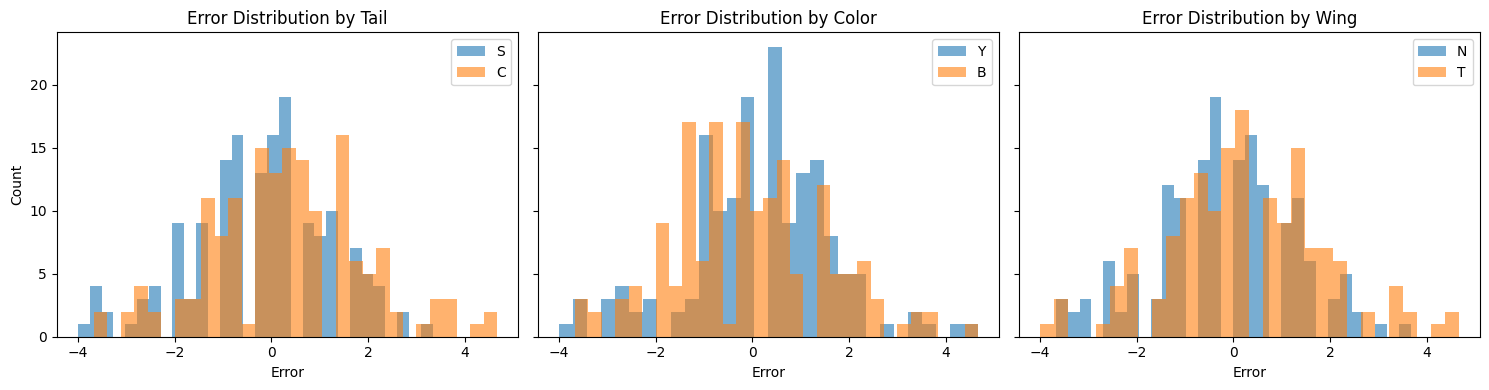

In [56]:
import matplotlib.pyplot as plt

# Make sure error is numeric
df_merged['error'] = pd.to_numeric(df_merged['error'])

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Tail
for t in df_merged['tail'].unique():
    print(t)
    axes[0].hist(
        df_merged.loc[df_merged['tail'] == t, 'error'],
        bins=30,
        alpha=0.6,
        label=t
    )
axes[0].set_title('Error Distribution by Tail')
axes[0].set_xlabel('Error')
axes[0].set_ylabel('Count')
axes[0].legend()

# --- Color ---
for c in df_merged['color'].unique():
    axes[1].hist(
        df_merged.loc[df_merged['color'] == c, 'error'],
        bins=30,
        alpha=0.6,
        label=c
    )
axes[1].set_title('Error Distribution by Color')
axes[1].set_xlabel('Error')
axes[1].legend()

# --- Wing ---
for w in df_merged['wing'].unique():
    axes[2].hist(
        df_merged.loc[df_merged['wing'] == w, 'error'],
        bins=30,
        alpha=0.6,
        label=w
    )
axes[2].set_title('Error Distribution by Wing')
axes[2].set_xlabel('Error')
axes[2].legend()

plt.tight_layout()
plt.show()


In [57]:
#Sanity Check: Mean absolute error by feature (shouldn't be very different)

df_merged[['wing', 'color', 'tail']] = df_merged['item'].str.split('_', expand=True)

print("Mean abs_error by tail:")
print(df_merged.groupby('tail')['abs_error'].mean())

print("Mean abs_error by color:")
print(df_merged.groupby('color')['abs_error'].mean())

print("Mean abs_error by wing:")
print(df_merged.groupby('wing')['abs_error'].mean())
#t-test: color 1 vs color 2 absolute error 
color1 = df_merged.loc[df_merged['color'] == 'B', 'abs_error']
color2 = df_merged.loc[df_merged['color'] == 'Y', 'abs_error']
t_stat, p_val = stats.ttest_ind(pd.to_numeric(color1), pd.to_numeric(color2), equal_var=False)  # Welch's t-test
print(f"T = {t_stat:.3f}, p = {p_val:.3f}")


Mean abs_error by tail:
tail
C       1.25
S    1.14375
Name: abs_error, dtype: object
Mean abs_error by color:
color
B    1.260417
Y    1.133333
Name: abs_error, dtype: object
Mean abs_error by wing:
wing
N    1.135417
T    1.258333
Name: abs_error, dtype: object
T = 1.161, p = 0.247


In [58]:
#t-test: predict vs accomodate absolute error
df_merged['abs_error'] = pd.to_numeric(df_merged['abs_error'])
print(df_merged.groupby('task')['abs_error'].mean())
errors_task1 = df_merged.loc[df_merged['task'] == 'accommodate', 'abs_error']
errors_task2 = df_merged.loc[df_merged['task'] == 'predict', 'abs_error']
from scipy import stats
t_stat, p_val = stats.ttest_ind(errors_task1, errors_task2, equal_var=False)  # Welch's t-test
print(f"T = {t_stat:.3f}, p = {p_val:.3f}")
summary_df = pd.DataFrame({
    "task": ["accommodate", "predict"],
    "mean_abs_error": [errors_task1.mean(), errors_task2.mean()],
    "t_stat": [t_stat, t_stat], 
    "p_value": [p_val, p_val]    
})

# Save CSV
#summary_df.to_csv(os.path.join(outputdir, "ttest_error.csv"))

task
accommodate    1.229167
predict        1.164583
Name: abs_error, dtype: float64
T = 0.589, p = 0.556


Part 2: Correlations

In [59]:
print(df_merged.head(20))

           task  conditionOrder   item testing_responses relevant_dim_1  \
0   accommodate              11  N_Y_S               8.0          color   
1   accommodate              11  T_Y_S               4.0          color   
2   accommodate              11  T_Y_C               3.0          color   
3   accommodate              11  N_B_S               7.0          color   
4   accommodate              11  T_B_C               3.0          color   
5   accommodate              11  N_B_C               9.0          color   
6   accommodate              11  N_Y_C               6.0          color   
7   accommodate              11  T_B_S               4.0          color   
8   accommodate              14  T_B_S               5.0          color   
9   accommodate              14  N_B_S               7.0          color   
10  accommodate              14  N_Y_S               4.0          color   
11  accommodate              14  N_Y_C               3.0          color   
12  accommodate          

In [65]:
print(df_merged)

            task  conditionOrder   item testing_responses relevant_dim_1  \
0    accommodate              11  N_Y_S               8.0          color   
1    accommodate              11  T_Y_S               4.0          color   
2    accommodate              11  T_Y_C               3.0          color   
3    accommodate              11  N_B_S               7.0          color   
4    accommodate              11  T_B_C               3.0          color   
..           ...             ...    ...               ...            ...   
315      predict               8  N_B_C               7.0           tail   
316      predict               8  T_B_C               7.0           tail   
317      predict               8  T_Y_S               8.0           tail   
318      predict               8  N_Y_S               5.0           tail   
319      predict               8  T_Y_C               5.0           tail   

    relevant_dim_2 irrelevant_dim color_high tail_high wing_high food_amount  \
0      

In [67]:
# Columns indicating whether the item's feature is the "high" dimension (1 or 0 coding)
df_merged['tail_match_high']  = (df_merged['tail']  == df_merged['tail_high']).astype(int)
df_merged['color_match_high'] = (df_merged['color'] == df_merged['color_high']).astype(int)
df_merged['wing_match_high'] = (df_merged['wing'] == df_merged['wing_high']).astype(int)
#print(df_merged.head(20))
# Group by participant
participant_corrs = []

for pid, g in df_merged.groupby(['task', 'conditionOrder']):
    for feat in ['tail','color','wing']:
        # Column indicating match to high value
        match_col = f"{feat}_match_high"
        
        # Compute correlation
        corr = g['testing_responses'].corr(g[match_col])
        
        # Determine if this feature is relevant for this participant
        relevant = feat in [g['relevant_dim_1'].iloc[0], g['relevant_dim_2'].iloc[0]]
        high_col  = f"{feat}_high"
        
        # Store
        participant_corrs.append({
            'participant': pid,
            'task': g['task'].iloc[0],
            'feature_dimension': feat,
            'high_value': g[high_col].iloc[0],
            'feature_relevance': 'relevant' if relevant else 'irrelevant',
            'correlation': corr,
            'irrelevant_dim': g['irrelevant_dim'].iloc[0],
            'abs_correlation': abs(corr) if pd.notna(corr) else None
        })

df_corr = pd.DataFrame(participant_corrs)
print(df_corr.head(40))



          participant         task feature_dimension high_value  \
0    (accommodate, 1)  accommodate              tail          C   
1    (accommodate, 1)  accommodate             color          Y   
2    (accommodate, 1)  accommodate              wing          T   
3    (accommodate, 2)  accommodate              tail          S   
4    (accommodate, 2)  accommodate             color          B   
5    (accommodate, 2)  accommodate              wing          T   
6    (accommodate, 3)  accommodate              tail          S   
7    (accommodate, 3)  accommodate             color          Y   
8    (accommodate, 3)  accommodate              wing          N   
9    (accommodate, 4)  accommodate              tail          S   
10   (accommodate, 4)  accommodate             color          B   
11   (accommodate, 4)  accommodate              wing          N   
12   (accommodate, 5)  accommodate              tail          C   
13   (accommodate, 5)  accommodate             color          

In [73]:
df_wing2 = df_corr[df_corr["feature_dimension"] == "wing"].copy()
df_wing2["wing_relevant"] = (df_wing2["feature_relevance"] == "relevant").astype(int) #Code relevancy as 0/1
df_wing2["wing_present"] = (df_wing2["high_value"] == "T").astype(int) #Code relevancy as 0/1

print(df_wing2)

           participant         task feature_dimension high_value  \
2     (accommodate, 1)  accommodate              wing          T   
5     (accommodate, 2)  accommodate              wing          T   
8     (accommodate, 3)  accommodate              wing          N   
11    (accommodate, 4)  accommodate              wing          N   
14    (accommodate, 5)  accommodate              wing          T   
17    (accommodate, 6)  accommodate              wing          T   
20    (accommodate, 7)  accommodate              wing          N   
23    (accommodate, 8)  accommodate              wing          T   
26    (accommodate, 9)  accommodate              wing          T   
29   (accommodate, 10)  accommodate              wing          T   
32   (accommodate, 11)  accommodate              wing          N   
35   (accommodate, 12)  accommodate              wing          T   
38   (accommodate, 13)  accommodate              wing          T   
41   (accommodate, 14)  accommodate             

In [74]:
avg_corr_task_rel = df_wing2.groupby(
    ['task', 'wing_present'],
    as_index=False
)['correlation'].mean()
print(avg_corr_task_rel)

          task  wing_present  correlation
0  accommodate             0     0.409105
1  accommodate             1     0.465599
2      predict             0     0.352217
3      predict             1     0.545848


In [75]:
avg_corr_task_rel = df_wing2.groupby(
    ['task', 'wing_relevant', 'wing_present'],
    as_index=False
)['correlation'].mean()
print(avg_corr_task_rel)

          task  wing_relevant  wing_present  correlation
0  accommodate              0             0     0.147170
1  accommodate              0             1     0.346537
2  accommodate              1             0     0.513879
3  accommodate              1             1     0.656098
4      predict              0             0     0.306320
5      predict              0             1     0.437886
6      predict              1             0     0.370576
7      predict              1             1     0.718586


In [199]:
avg_corr_task_rel = df_corr.groupby(
    ['task'],
    as_index=False
)['correlation'].mean()

print(avg_corr_task_rel)
avg_corr_feature = df_corr.groupby(
    ['feature_dimension'],
    as_index=False
)['correlation'].mean()

print(avg_corr_feature)
avg_corr_relevance = df_corr.groupby(
    ['feature_relevance'],
    as_index=False
)['correlation'].mean()

print(avg_corr_relevance)

          task  correlation
0  accommodate     0.319385
1      predict     0.331335
  feature_dimension  correlation
0             color     0.305330
1              tail     0.208799
2              wing     0.461952
  feature_relevance  correlation
0        irrelevant     0.237239
1          relevant     0.369421


In [221]:
avg_corr_feature = df_corr.groupby(
    ['task', 'feature_dimension'],
    as_index=False
)['correlation'].mean()
print(avg_corr_feature)


          task feature_dimension  correlation
0  accommodate             color     0.316916
1  accommodate              tail     0.195413
2  accommodate              wing     0.445826
3      predict             color     0.293743
4      predict              tail     0.222185
5      predict              wing     0.478077


In [ ]:
avg_corr_task_rel = df_corr.groupby(
    ['task'],
    as_index=False
)['correlation'].mean()

print(avg_corr_task_rel)
avg_corr_feature = df_corr.groupby(
    ['feature_dimension'],
    as_index=False
)['correlation'].mean()

print(avg_corr_feature)
avg_corr_relevance = df_corr.groupby(
    ['feature_relevance'],
    as_index=False
)['correlation'].mean()

print(avg_corr_relevance)

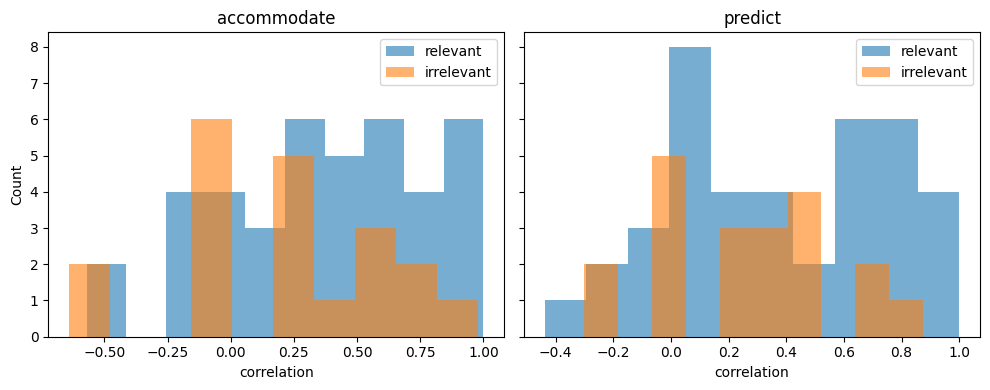

In [200]:
tasks = df_corr['task'].unique()

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(tasks),
    figsize=(5 * len(tasks), 4),
    sharey=True
)

if len(tasks) == 1:
    axes = [axes]

for ax, task in zip(axes, tasks):
    for label in ['relevant', 'irrelevant']:
        values = df_corr.loc[
            (df_corr['task'] == task) &
            (df_corr['feature_relevance'] == label),
            'correlation'
        ]
        ax.hist(values, bins=10, alpha=0.6, label=label)

    ax.set_title(task)
    ax.set_xlabel("correlation")
    ax.legend()

axes[0].set_ylabel("Count")

plt.tight_layout()
#plt.savefig(os.path.join(outputdir, 'Figure5_FeatureCorrelationeByTaskAndRelevance.png'), dpi=300)
plt.show()


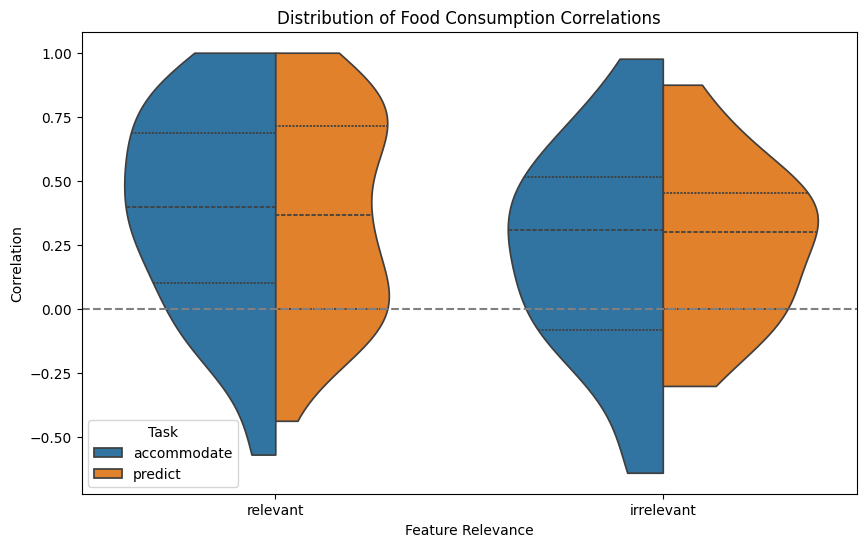

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Violin plot: distribution of ratings by task and relevance
sns.violinplot(
    data=df_corr,
    x='feature_relevance',      # relevant / irrelevant
    y='correlation',     # -7 to 7
    hue='task',                 # predict / accomodate
    split=True,                 # split the violins by hue
    inner='quartile',            # show median and quartiles
    cut = 0
)

plt.axhline(0, color='gray', linestyle='--')  # line at 0
plt.title('Distribution of Food Consumption Correlations')
plt.ylabel('Correlation')
plt.xlabel('Feature Relevance')
plt.legend(title='Task')
#plt.savefig(os.path.join(outputdir, 'Figure5_FeatureCorrelationeByTaskAndRelevanceViolin.png'), dpi=300)

plt.show()


In [202]:
avg_corr_task_rel = df_corr.groupby(
    ['task', 'feature_relevance'],
    as_index=False
)['correlation'].mean()

print(avg_corr_task_rel)


          task feature_relevance  correlation
0  accommodate        irrelevant     0.213229
1  accommodate          relevant     0.372463
2      predict        irrelevant     0.261248
3      predict          relevant     0.366378


In [31]:
nan_corrs = df_corr[pd.isna(df_corr['correlation'])]
#print(nan_corrs)
df_corr_clean = df_corr[pd.notna(df_corr['correlation'])].copy()



In [32]:
import statsmodels.formula.api as smf

md = smf.mixedlm(
    "correlation ~ task * feature_relevance",
    df_corr_clean,
    groups=df_corr_clean["participant"],  # random intercept per participant
    re_formula="~feature_relevance"  # random slopes if it converges
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())
mdf.summary().tables[1].to_csv(os.path.join(outputdir, "mixedlm_correlation.csv"))


                         Mixed Linear Model Regression Results
Model:                       MixedLM           Dependent Variable:           correlation
No. Observations:            891               Method:                       REML       
No. Groups:                  297               Scale:                        0.1532     
Min. group size:             3                 Log-Likelihood:               -454.1848  
Max. group size:             3                 Converged:                    Yes        
Mean group size:             3.0                                                        
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.042    0.033  1.286 0.199 -0.022  0.106
task[T.predict]                               -

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [33]:
avg_corr_task_rel = df_corr.groupby(
    ['task'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_task_rel)
avg_corr_feature = df_corr.groupby(
    ['feature_dimension'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_feature)
avg_corr_relevance = df_corr.groupby(
    ['feature_relevance'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_relevance)
avg_corr_task_rel = df_corr.groupby(
    ['task', 'feature_relevance'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_task_rel)


          task  abs_correlation
0  accommodate         0.411739
1      predict         0.405231
  feature_dimension  abs_correlation
0             color         0.421221
1             shape         0.373962
2              tail         0.430240
  feature_relevance  abs_correlation
0        irrelevant         0.301135
1          relevant         0.462144
          task feature_relevance  abs_correlation
0  accommodate        irrelevant         0.299021
1  accommodate          relevant         0.468098
2      predict        irrelevant         0.303235
3      predict          relevant         0.456230


In [34]:
import statsmodels.formula.api as smf

md = smf.mixedlm(
    "abs_correlation ~ task * feature_relevance",
    df_corr_clean,
    groups=df_corr_clean["participant"],  # random intercept per participant
    re_formula="~feature_relevance"  # optional random slopes if it converges
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())


                         Mixed Linear Model Regression Results
Model:                     MixedLM          Dependent Variable:          abs_correlation
No. Observations:          891              Method:                      REML           
No. Groups:                297              Scale:                       0.0678         
Min. group size:           3                Log-Likelihood:              -92.7376       
Max. group size:           3                Converged:                   Yes            
Mean group size:           3.0                                                          
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.299    0.022 13.537 0.000  0.256  0.342
task[T.predict]                                

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Supplementary: Impact of Food Dimension

In [ ]:
# Predicting feature importance from task and feature relevance, with random intercepts for participants
md = smf.mixedlm(
    "feature_importance ~ task * feature_relevance * irrelevant_dim",
    df_long,
    groups=df_long["participant"],  # random intercept per participant
    re_formula="~feature_relevance" # random slopes
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())
mdf.summary().tables[1].to_csv(os.path.join(outputdir, "mixedlm_featureimportanceWithDimensions.csv"))


                                     Mixed Linear Model Regression Results
Model:                            MixedLM                 Dependent Variable:                 feature_importance
No. Observations:                 900                     Method:                             REML              
No. Groups:                       300                     Scale:                              10.2613           
Min. group size:                  3                       Log-Likelihood:                     -2374.4307        
Max. group size:                  3                       Converged:                          Yes               
Mean group size:                  3.0                                                                           
----------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------

In [ ]:
# Predicting correlation from task and feature relevance, with random intercepts for participants

md = smf.mixedlm(
    "correlation ~ task * feature_relevance * irrelevant_dim",
    df_corr_clean,
    groups=df_corr_clean["participant"],  # random intercept per participant
    re_formula="~feature_relevance"  # optional random slopes if it converges
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())
mdf.summary().tables[1].to_csv(os.path.join(outputdir, "mixedlm_correlationWithDimensions.csv"))


                                     Mixed Linear Model Regression Results
Model:                               MixedLM                   Dependent Variable:                   correlation
No. Observations:                    891                       Method:                               REML       
No. Groups:                          297                       Scale:                                0.1516     
Min. group size:                     3                         Log-Likelihood:                       -462.8681  
Max. group size:                     3                         Converged:                            Yes        
Mean group size:                     3.0                                                                        
----------------------------------------------------------------------------------------------------------------
                                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Supplementary: Irrelevant Feature Association with food amount and food consumption ratings

In [55]:
df_irrel = df_merged[df_merged['irrelevant_dim'].notna()].copy()
# Create participant identifier
df_irrel['participant'] = df_irrel['task'].astype(str) + "_" + df_irrel['conditionOrder'].astype(str)

# Pick the correct irrelevant column
def get_irrel_value(row):
    if row['irrelevant_dim'] == 'color':
        return row['color_match_high']
    elif row['irrelevant_dim'] == 'tail':
        return row['tail_match_high']
    elif row['irrelevant_dim'] == 'shape':
        return row['shape_match_high']

df_irrel['irrel_value'] = df_irrel.apply(get_irrel_value, axis=1)

# Compute correlation between food amount and the high irrelevant feature value for each participant
def compute_irrel_corr(sub):
    return sub['irrel_value'].corr(sub['food_amount'])

corrs = df_irrel.groupby('participant').apply(compute_irrel_corr).reset_index()
corrs = corrs.rename(columns={0: 'irrel_corr'})

# Merge back into df_irrel
df_irrel = df_irrel.merge(corrs, on='participant')

print(df_irrel.head(20))



           task  conditionOrder   item testing_responses relevant_dim_1  \
0   accommodate              85  N_Y_S               5.0          color   
1   accommodate              85  N_Y_C               3.0          color   
2   accommodate              85  N_B_S               6.0          color   
3   accommodate              85  N_B_C               8.0          color   
4   accommodate              85  T_B_C               6.0          color   
5   accommodate              85  T_B_S               5.0          color   
6   accommodate              85  T_Y_C               2.0          color   
7   accommodate              85  T_Y_S               2.0          color   
8   accommodate              12  T_Y_S               6.0          color   
9   accommodate              12  T_B_S               4.0          color   
10  accommodate              12  N_Y_S               8.0          color   
11  accommodate              12  N_Y_C               8.0          color   
12  accommodate          

/var/folders/t5/wz7tq5fx44j9z9q48fv6hc0c0000gq/T/ipykernel_85942/843859331.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corrs = df_irrel.groupby('participant').apply(compute_irrel_corr).reset_index()


             task  conditionOrder   item testing_responses relevant_dim_1  \
1     accommodate              85  N_Y_C               3.0          color   
3     accommodate              85  N_B_C               8.0          color   
4     accommodate              85  T_B_C               6.0          color   
6     accommodate              85  T_Y_C               2.0          color   
8     accommodate              12  T_Y_S               6.0          color   
...           ...             ...    ...               ...            ...   
2390      predict              87  N_Y_C               6.0          shape   
2392      predict              13  N_B_S               6.0          shape   
2393      predict              13  N_Y_C               3.0          shape   
2394      predict              13  N_B_C               4.0          shape   
2395      predict              13  N_Y_S               5.0          shape   

     relevant_dim_2 irrelevant_dim color_high tail_high shape_high  ...  \


<Figure size 600x400 with 0 Axes>

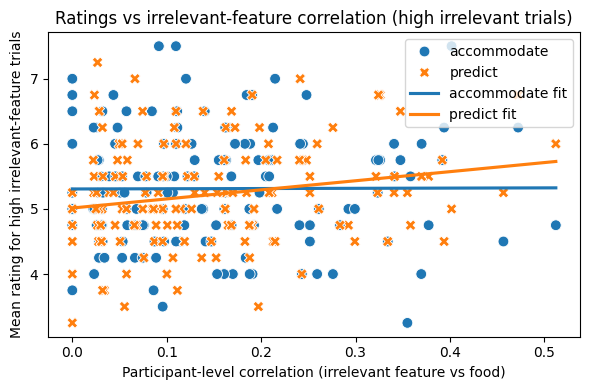

In [ ]:
# High irrelevant feature trials
high_trials = df_irrel[df_irrel['irrel_value'] == 1]
print(high_trials)

# Average rating for high-irrelevant trials per participant, keeping task
mean_high_response = high_trials.groupby(['participant', 'task'])['testing_responses'].mean().reset_index()
mean_high_response = mean_high_response.rename(columns={'testing_responses': 'mean_high_response'})

# Get participant-level irrelevant-feature correlation, also keeping task
irrel_corr = df_irrel.groupby(['participant', 'task'])['irrel_corr'].first().reset_index()

# Merge
participant_summary = mean_high_response.merge(irrel_corr, on=['participant', 'task'])

# Plot

plt.figure(figsize=(6,4))

# Scatter points
sns.scatterplot(
    data=participant_summary,
    x='irrel_corr',
    y='mean_high_response',
    hue='task',
    style='task',
    s=60
)

# Regression line per task
for task, sub in participant_summary.groupby('task'):
    sns.regplot(
        data=sub,
        x='irrel_corr',
        y='mean_high_response',
        scatter=False,
        ci=None,
        label=f"{task} fit"
    )

plt.xlabel("Participant-level correlation (irrelevant feature vs food)")
plt.ylabel("Mean rating for high irrelevant-feature trials")
plt.title("Ratings vs irrelevant-feature correlation (high irrelevant trials)")
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
model = smf.ols(
    "mean_high_response ~ irrel_corr * task",
    data=participant_summary
).fit()

print(model.summary())

ValueError: endog has evaluated to an array with multiple columns that has shape (300, 18). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

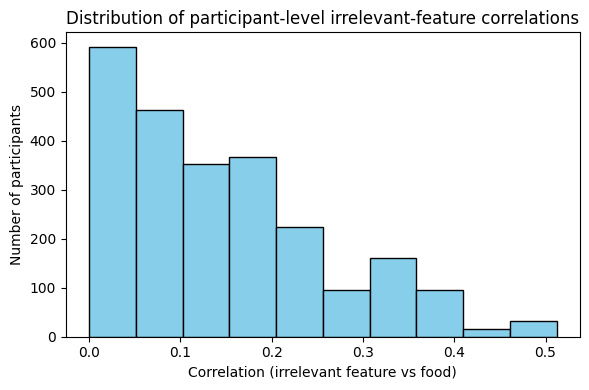

In [ ]:
import matplotlib.pyplot as plt

# Get unique correlations per participant
participant_corrs = df_irrel[['participant', 'irrel_corr']]

plt.figure(figsize=(6,4))
plt.hist(participant_corrs['irrel_corr'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Correlation (irrelevant feature vs food)")
plt.ylabel("Number of participants")
plt.title("Distribution of participant-level irrelevant-feature correlations")
plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.formula.api as smf
df_irrel['testing_responses'] = pd.to_numeric(df_irrel['testing_responses'], errors='coerce')
df_irrel = df_irrel.dropna(subset=['testing_responses'])
md = smf.mixedlm(
    "testing_responses ~ task * irrel_corr",
    df_irrel,
    groups=df_irrel["participant"],    # random intercept
    re_formula="~irrel_corr"           # random slope
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())


                Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   testing_responses
No. Observations:   2400      Method:               REML             
No. Groups:         300       Scale:                3.2561           
Min. group size:    8         Log-Likelihood:       -4823.9029       
Max. group size:    8         Converged:            Yes              
Mean group size:    8.0                                              
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   5.286    0.084 62.855 0.000  5.122  5.451
task[T.predict]            -0.113    0.119 -0.946 0.344 -0.346  0.121
irrel_corr                 -0.506    0.452 -1.120 0.263 -1.391  0.379
task[T.predict]:irrel_corr  0.828    0.640  1.293 0.196 -0.427  2.082
Group Var                   0.000   

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<Figure size 600x400 with 0 Axes>

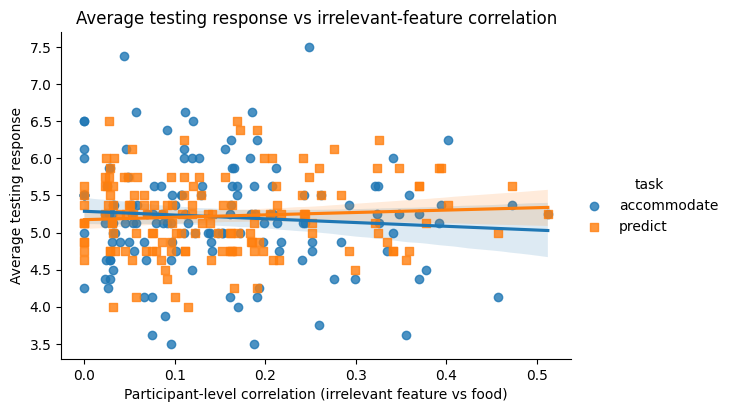

In [ ]:
import seaborn as sns
# Average trial responses per participant
participant_avg = df_irrel.groupby('participant').agg(
    mean_response=('testing_responses', 'mean'),
    irrel_corr=('irrel_corr', 'first'),   # same per participant
    task=('task', 'first')
).reset_index()
plt.figure(figsize=(6,4))
sns.lmplot(
    data=participant_avg,
    x='irrel_corr',
    y='mean_response',
    hue='task',      # regression line per task
    height=4,
    aspect=1.5,
    markers=["o","s"]
)
plt.xlabel("Participant-level correlation (irrelevant feature vs food)")
plt.ylabel("Average testing response")
plt.title("Average testing response vs irrelevant-feature correlation")
plt.show()


Supplementary Models Looking at Feature Dimension

In [ ]:
import ast
import matplotlib.pyplot as plt
#Calculate reported food amounts during testing
def AverageFoodCalclator(participants_to_use):
    df_subset = df_combined[df_combined['participant'].isin(participants_to_use)]
    all_trials = []
    for i in df_subset['participant']:
        ratings     = df_subset[df_subset['participant'] == i]['testing_responses'].iloc[0]
        categories = df_subset[df_subset['participant'] == i]['testing_categories'].iloc[0]
        task = df_subset[df_subset['participant'] == i]['task'].iloc[0]
        row = df_subset[df_subset['participant'] == i].iloc[0]
        tail_yes  = 1 if row['tail_discrete_slider.response']  == 'Yes' else 0
        shape_yes = 1 if row['shape_discrete_slider.response'] == 'Yes' else 0
        color_yes = 1 if row['color_discrete_slider.response'] == 'Yes' else 0
        num_features_relevant = tail_yes + shape_yes + color_yes
        df_participant = pd.DataFrame(list(zip(
            [i]*len(ratings),  # Repeat participant ID and task to match the number of ratings
            ratings,
            [task]*len(ratings), # Repeat participant ID and task to match the number of ratings
            categories,
            [num_features_relevant]*len(ratings)
        )), columns=['participant', 'ratings', 'task', 'category', 'num_features_relevant'])
        all_trials.append(df_participant)
    df_average = pd.concat(all_trials, ignore_index=True)
    avg_ratings_cond = df_average.groupby(['task', 'category'])['ratings'].mean()
    return df_average, avg_ratings_cond

participants_to_use = df_combined['participant'].tolist()
df_average, avg_rating_cond = AverageFoodCalclator(participants_to_use)
print(avg_rating_cond)
print(df_average)
# Group by task, category, and num_features_relevant
model_parameter_score = df_average.groupby(
    ['num_features_relevant']
)['ratings'].mean().reset_index()

print(model_parameter_score)
# Group by task, category, and num_features_relevant
avg_ratings_cond_by_relevance = df_average.groupby(
    ['task', 'category', 'num_features_relevant']
)['ratings'].mean().reset_index()


print(avg_ratings_cond_by_relevance)
category_order = ['low', 'medium', 'high']
avg_ratings_cond_by_relevance['category'] = pd.Categorical(
    avg_ratings_cond_by_relevance['category'],
    categories=category_order,
    ordered=True
)
import seaborn as sns
sns.catplot(
    data=avg_ratings_cond_by_relevance,
    x='category', y='ratings',
    hue='num_features_relevant', col='task',
    kind='bar', palette='Set2'
)
plt.show()

<Axes: xlabel='category', ylabel='ratings'>

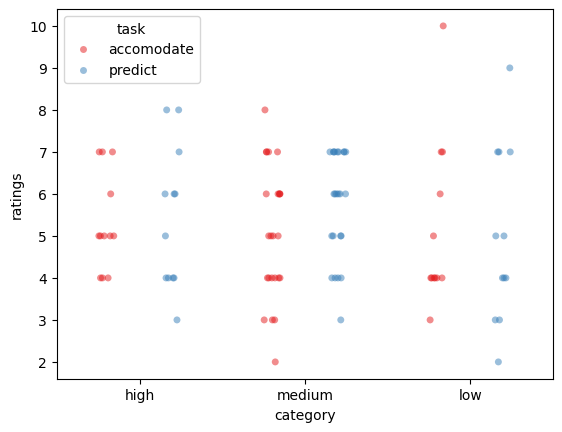

In [ ]:
sns.stripplot(data=df_average, x='category', y='ratings', hue='task', 
              palette='Set1', dodge=True, jitter=True, color='black', alpha=0.5)

In [ ]:
print(df_average.head(20))

    participant  ratings        task category  num_features_relevant
0             1      6.0  accomodate     high                      1
1             1      5.0  accomodate   medium                      1
2             1      3.0  accomodate      low                      1
3             1      5.0  accomodate   medium                      1
4             1      5.0  accomodate   medium                      1
5             1      7.0  accomodate     high                      1
6             1      4.0  accomodate      low                      1
7             1      4.0  accomodate   medium                      1
8             2      5.0  accomodate   medium                      2
9             2      3.0  accomodate   medium                      2
10            2      5.0  accomodate     high                      2
11            2      7.0  accomodate      low                      2
12            2      7.0  accomodate     high                      2
13            2      5.0  accomoda

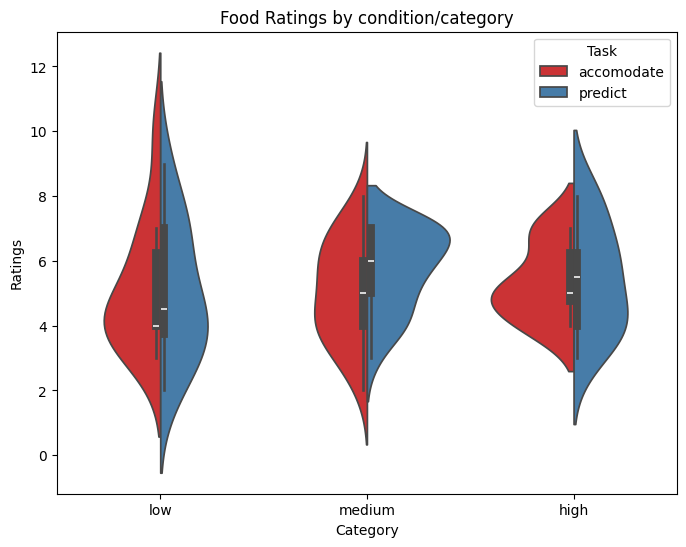

In [ ]:
order = ['low', 'medium', 'high']
# Violin plot: ratings by category, separated by task
plt.figure(figsize=(8,6))
sns.violinplot(
    data=df_average,
    x='category',       # x-axis: categories
    y='ratings',        # y-axis: ratings
    hue='task',         # split by task
    split=True,         # split the violins by task
    palette='Set1',
    inner='box',    # show box plot of data inside
    order = order
)

plt.ylabel('Ratings')
plt.xlabel('Category')
plt.title('Food Ratings by condition/category')
plt.legend(title='Task')
#plt.savefig(f'{study}Plots/ViolinRatings.png', bbox_inches='tight')
plt.show()

In [ ]:
def decode_rel(rel_values):
    """
    rel_values: Series of lists of rel codes
    """

    flat_vals = []
    for v in rel_values:
        if isinstance(v, list):
            flat_vals.extend(v)

    flat_vals = pd.Series(flat_vals).dropna().unique()

    if len(flat_vals) == 0:
        return pd.Series({'feature_relevance': np.nan})

    # irrelevant: only I-codes
    if all(v.startswith('I') for v in flat_vals):
        return pd.Series({'feature_relevance': 'irrelevant'})

    # relevant: contains R or L
    if any(v.startswith(('R', 'L')) for v in flat_vals):
        return pd.Series({'feature_relevance': 'relevant'})

    raise ValueError(f"Unexpected rel codes: {flat_vals}")


feature_relevance_rows = []

for (cond, task), subdf in df_combined.groupby(['conditionOrder', 'task']):
    for feat in ['tail', 'color', 'shape']:
        relevance = decode_rel(subdf[f'training_{feat}'])

        feature_relevance_rows.append({
            'conditionOrder': cond,
            'task': task,
            'feature_dimension': feat,
            'feature_relevance': relevance
        })

df_feature_relevance = pd.DataFrame(feature_relevance_rows)
print(df_feature_relevance)

    conditionOrder        task feature_dimension  \
0                1  accomodate              tail   
1                1  accomodate             color   
2                1  accomodate             shape   
3                1     predict              tail   
4                1     predict             color   
5                1     predict             shape   
6                2  accomodate              tail   
7                2  accomodate             color   
8                2  accomodate             shape   
9                2     predict              tail   
10               2     predict             color   
11               2     predict             shape   
12               3  accomodate              tail   
13               3  accomodate             color   
14               3  accomodate             shape   
15               3     predict              tail   
16               3     predict             color   
17               3     predict             shape   
18          

In [ ]:
features = ['shape', 'color', 'tail']
long_rows = []

for _, row in df_combined.iterrows():
    for feat in features:
        long_rows.append({
            'participant': row['participant'],
            'conditionOrder': row['conditionOrder'],
            'task': row['task'],
            'feature_dimension': feat,

            'discrete': row[f'{feat}_discrete_slider.response'],
            'direction': row[f'{feat}_direction_slider.response'],
            'continuous': row[f'{feat}_continuous_slider.response'],
        })

df_long = pd.DataFrame(long_rows)
print(df_long.head(10))

   participant  conditionOrder        task feature_dimension discrete  \
0            1               4  accomodate             shape      Yes   
1            1               4  accomodate             color       No   
2            1               4  accomodate              tail       No   
3            2               1  accomodate             shape       No   
4            2               1  accomodate             color      Yes   
5            2               1  accomodate              tail      Yes   
6            3               3  accomodate             shape      Yes   
7            3               3  accomodate             color      Yes   
8            3               3  accomodate              tail      Yes   
9            4               2  accomodate             shape      Yes   

       direction  continuous  
0         Square         5.0  
1            NaN         NaN  
2            NaN         NaN  
3            NaN         NaN  
4           Blue         4.0  
5  Having 

In [ ]:
df_long = df_long.merge(
    df_feature_relevance,
    on=['conditionOrder', 'task', 'feature_dimension'],
    how='left'
)
print(df_long.head(21))

    participant  conditionOrder        task feature_dimension discrete  \
0             1               4  accomodate             shape      Yes   
1             1               4  accomodate             color       No   
2             1               4  accomodate              tail       No   
3             2               1  accomodate             shape       No   
4             2               1  accomodate             color      Yes   
5             2               1  accomodate              tail      Yes   
6             3               3  accomodate             shape      Yes   
7             3               3  accomodate             color      Yes   
8             3               3  accomodate              tail      Yes   
9             4               2  accomodate             shape      Yes   
10            4               2  accomodate             color      Yes   
11            4               2  accomodate              tail      Yes   
12            5               2     pr